# Transfer Learning


### Ideas
* Dataset: use a simple dataset from TensorFlow Dataset like MNIST, KMNIST, or FashionMNIST, or even cats vs dogs which is a little bigger.
* Model Options: 
  * `jax-resnet`: has the benefit of being small and fast.
  * `FlaxCLIPVisionModel`: would showcase how to use HuggingFace models.

### Important Links
- https://github.com/google/flax/discussions/1706
- https://github.com/google/flax/discussions/2245

### Outline
* Introduction
* Creating the model
  * Loading pretrained module
  * Creating a model for the new task
  * Transfering pretrained parameters
* Optimization Procedure
  * Discuss Options
    * Using `stop_gradient`
    * Taking gradients w.r.t. trainable parameters only
    * Zeroing out gradients for non-trainable parameters
  * Using Optax `multi_transform` + `variables_path_partitions`
    * Completely freezing layers
    * Using different learning rates
* Training the model

## Introduction

### What is Transfer Learning?
Theory
* Pretrain on a base task, use the learned parameters to train on a target task
* Works if the representation learned on the base task are useful for the target task
* Usually done when you have a small dataset for the target task
* The more general base task is the higher the chance that the representations learned are useful for the target task, models trained via Self Supervised Learning (e.g `BERT`) are good candidates.

Options in Practice
* Fine-tuning: use the pretrained weights as a starting point but train the whole model on the new task. This is commonly done in NLP tasks.
* Extract features: use the pretrained model to extract the features for the target task and train a new model on those features. This is commonly done in vision tasks. (mention pre-computing all embeddings as an optimization)
* Hybrid: you can interpolate between the two previous approaches by deciding how much of the pretrained model remains frozen and how much is trained, e.g. freeze the last few layers and train the rest. Apart from that you can also interpolate between freezing and training by using different learning rates per layer where freezing is just the extreme case of the learning rate being 0.

### Project Description
For this tutorial we will be creating a model for a simple Computer Vision classification task on a small dataset, more specifically we will using a pretrained `MlpMixer` Flax model from the [vision_transformer](https://github.com/google-research/vision_transformer) repository to learn the [rock_paper_scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) dataset from TensorFlow Datasets.

## Creating the model
The first thing you need to do is load a pretrained, depending on which model/library you are using this might look wildly different but in general you will have to get hold of the following:

* The Flax `Module` that defines the model architecture.
* The model parameters (and batch statistics for models that use batch norm).
* The preprocessing procedure that converts the raw inputs into the format the model expects, for images this is often a simple processing scripts that applies resize and some normalization, and for text this usually a tokenizer.

In this tutorial we will create an `MlpMixer` model using the `vit_jax` library from the `vision_transformer` repository. The thing we need to do is to install the `vit_jax` library:

In [ ]:
! pip install transformers[flax]

Now we will create a `load_model` function that will create the Flax module for the `MlpMixer` and download the pretrained weights from Google Storage. To do this we will leverage utility functions from the `models` and `checkpoint` modules from `jax_vit`.

In [1]:
import tensorflow as tf
from transformers import CLIPProcessor, FlaxCLIPVisionModel
from IPython.display import clear_output

def load_model():
  model = FlaxCLIPVisionModel.from_pretrained('openai/clip-vit-base-patch32')
  processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
  clear_output(wait=False) # clear the loading warnings messages

  # extract flax Module and variables
  module = model.module
  variables = {'params': model.params}

  def preprocess_np(image):
    return processor(images=image, return_tensors="np")['pixel_values'][0]

  def preprocess_fn(image):
    image = tf.numpy_function(preprocess_np, [image], tf.float32)
    return tf.transpose(image, (1, 2, 0))

  return module, variables, preprocess_fn

2022-11-07 21:18:22.587204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 21:18:22.723564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-11-07 21:18:22.723600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-07 21:18:22.759940: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 21:18:23.641254

Here `models.get_model` creates a preconfigured `MlpMixer` instance, we set `num_classes=None` so it doesn't create the classifier layer as we will do that ourselves later. `checkpoint.copy` and `checkpoint.load` will help us download and load the `params` into memory. In this case the library did not provide a preprocessing function so based on their examples we created a `preprocess_fn` function that resizes the images to `224x224` and normalizes to values between -1 and 1 using TensorFlow as in JAX its common to use `tf.data` to preprocess the data.

Next we will create our own Flax Module which we will name `Classifier`, this module will consist of a `backbone` module (the `MlpMixer`) which will provide the embeddings and simple `head` Dense layer ontop which will map the embeddings to the logits for classification.

In [3]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Classifier(nn.Module):
  num_classes: int
  backbone: nn.Module

  @nn.compact
  def __call__(self, x):
    x = self.backbone(x).pooler_output
    x = nn.Dense(self.num_classes, name='head', kernel_init=nn.zeros)(x)
    return x

Now we can call `load_model` to get the `backbone` and pass it to `Classifier` to create our model. To test that everything works we will call the `tabulate` method with some dummy inputs to get a summary of the model.

In [4]:
num_classes = 3
backbone, pretrained_variables, process = load_model()
model = Classifier(num_classes=num_classes, backbone=backbone)

x = jnp.ones((1, 224, 224, 3))
print(model.tabulate(jax.random.PRNGKey(0), x, depth=1, console_kwargs=dict(width=1000)))


                                                    Classifier Summary                                                    
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module               ┃ inputs               ┃ outputs                              ┃ params                 ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│          │ Classifier           │ float32[1,224,224,3] │ float32[1,3]                         │                        │
├──────────┼──────────────────────┼──────────────────────┼──────────────────────────────────────┼────────────────────────┤
│ backbone │ FlaxCLIPVisionModule │ float32[1,224,224,3] │ attentions: None                     │ 87,456,000 (349.8 MB)  │
│          │                      │                      │ hidden_states: None                  │                        │
│          │   

Perfect, we now have a working Flax Module but we don't have the correct parameters yet. To get the full parameter structure we will first initialize the whole model with random weights using `.init()`.

In [5]:
x = jnp.ones((1, 224, 224, 3))
variables = model.init(jax.random.PRNGKey(1), x)

The `variables` structure will look like this: 
```
FrozenDict({
    params: {
        backbone: {...},
        head: {...},
    }
})
```
## Parameter surgery
Since `variables` are randomly initialized, we now have to transfer the parameters from `pretrained_variables` to `variables` at the appropriate location. This can be done by unfreezing `variables`, updating the `backbone` parameters, and freezing `variables` again.

In [6]:
from flax.core.frozen_dict import freeze



# transfer pretrained params to new model
variables = variables.unfreeze()
variables['params']['backbone'] = pretrained_variables['params']
variables = freeze(variables)

## Optimization Procedure

Now that we have a working model we can start to define how we will optimize it. As discussed in the beginning, the training procedure will depend on how much of the model we want to freeze and how much of the model we want to train. In JAX there are a couple of ways of doing this:

1. **Using `stop_gradient`**: JAX's `stop_gradient` function prevents the gradients from flowing during backpropagation at a given location, gradients w.r.t. parameters that were cut off will still be created but their values will be set to 0.
2. **Calculate the gradient w.r.t trainable parameters only**: `jax.grad` lets you explicitly choose w.r.t. which parameters the gradients will be computed, you can choose to pass the trainable parameters only effectivly freezing the non-trainable ones.
3. **Using multiple optimizers**: even if you compute the gradients w.r.t. all parameters you can still freeze certain layers excluding their gradients from the optimization procedure. As we will se later, [optax.multi_transform](https://optax.readthedocs.io/en/latest/api.html#optax.multi_transform) is a great tool for this.

While using `stop_gradient` initially sounds like a simple solution it has some drawbacks:
* Its not easy to insert `stop_gradient` calls into existing (3rd party) Modules.
* Its not a very flexible strategy as its not possible to freeze a given layer without freezing all the layers that came before it.

Between the other options we will recommend using using multiple optimizers via [optax.multi_transform](https://optax.readthedocs.io/en/latest/api.html#optax.multi_transform) because its as efficient as the `jax.grad` strategy and lets you easily switch between freezing layers and using differential learning rates by just changing the optimizers. Since JIT drops unused expressions, if the optimizer excludes certain gradients then their calculation might be dropped altogether.

## Freezing layers via optax.multi_transform
[optax.multi_transform](https://optax.readthedocs.io/en/latest/api.html#optax.multi_transform) lets you partition you parameters and apply a different optimizer for each partition. To use `multi_transform` you have to do two things:

1. Create a mappging between partitions and their correspoing optimizer, we will call this `partition_optimizers`.
2. Create a pytree with the same shape as that parameters but its leaves containing the partition label of the correspoing parameter, this effectively maps a parameter to a specific partition. We wil call this `param_partitions`.

We will use 2 partitions: `trainable` and `frozen`. For the trainable partition we will use the `adam` optimizer, while for the `frozen` partition we will use `optax.set_to_zero` which zero-out their gradients. To create `param_partitions` we will use `traverse_util.path_aware_map` function that will help use define the partition for each param by using the `path` information, we will set all parameters in the `backbone` as `frozen`. Our main optimizer which by convention is called `tx` will be the `multi_transform` GradientTransformation.

In [8]:
from flax import traverse_util
import optax

partition_optimizers = {'trainable': optax.adam(1e-3), 'frozen': optax.set_to_zero()}
param_partitions = freeze(traverse_util.path_aware_map(
  lambda path, v: 'frozen' if 'backbone' in path else 'trainable', variables['params']))
tx = optax.multi_transform(partition_optimizers, param_partitions)

# visualize a subset of the param_partitions structure
flat = list(traverse_util.flatten_dict(param_partitions).items())
freeze(traverse_util.unflatten_dict(dict(flat[:2] + flat[-2:])))

FrozenDict({
    backbone: {
        vision_model: {
            embeddings: {
                class_embedding: 'frozen',
                patch_embedding: {
                    kernel: 'frozen',
                },
            },
        },
    },
    head: {
        bias: 'trainable',
        kernel: 'trainable',
    },
})

As mentioned previously its easy to implement differential learning rates by just changing the optimizers:

In [ ]:
partition_optimizers = {
    'head': optax.adam(5e-3),   # normal learning rate
    'backbone': optax.sgd(1e-5) # small learning rate, different optimizer
} 
param_partitions = freeze(traverse_util.path_aware_map(
    lambda path, v: path[0], variables['params']))
diff_tx = optax.multi_transform(partition_optimizers, param_partitions)

Here we changed the partition names to simplify the logic. We will not be using this optimizer but you can rename `diff_tx` to just `tx` if want to try it out.

## Fine-tuning the model
Now that we have our model with its pretrained backbone and our optimizer that will freeze the backbone, we will now load some data, define our training and evaluation steps, and finish up by writting a simple training loop.

### Creating the Dataset
We will be loading the [rock_paper_scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) dataset from TensorFlow Datasets, its a very small and simple dataset consisting of 3D rendered images of hands doing the poses from the rock-paper-scissors game, the goal is to classify each pose. We will define a `preprocess_dataset` helper function that will take a raw dataset and do some basic preprocessing, shuffling and batching the data, etc, which we will use to preprocess both the training and testing datasets.

In [17]:
%%capture
import tensorflow_datasets as tfds

batch_size = 32
label_names = {0: 'rock', 1: 'paper', 2: 'scissors'}

def preprocess_dataset(
    ds: tf.data.Dataset, *, batch_size: int, train: bool) -> tf.data.Dataset:
    def map_fn(image, label):
        image = process(image)
        return image, label
    if train:
        ds = ds.repeat()
    ds = ds.map(map_fn)
    if train:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds

train_ds_raw = tfds.load('rock_paper_scissors', split='train', as_supervised=True, shuffle_files=True)
test_ds_raw = tfds.load('rock_paper_scissors', split='test', as_supervised=True)
train_size, test_size = len(train_ds_raw), len(test_ds_raw)

train_ds = preprocess_dataset(train_ds_raw, batch_size=batch_size, train=True)
test_ds = preprocess_dataset(test_ds_raw, batch_size=batch_size, train=False)

To get a feel of the data lets visualize a couple of samples from `train_ds_raw`.

Train size: 2520
Test size: 372


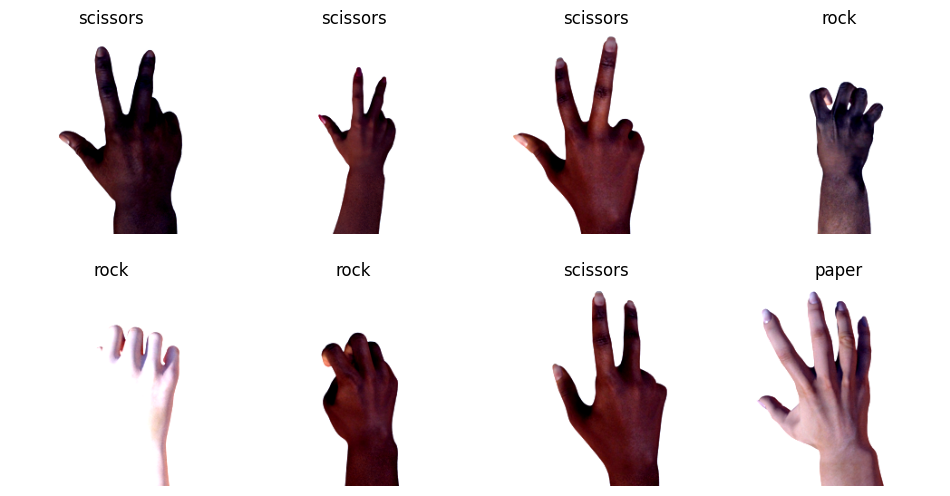

In [18]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = train_ds.take(1).as_numpy_iterator().next()

# create a 2x3 grid plot of images
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

print(f'Train size: {train_size}')
print(f'Test size: {test_size}')
for i in range(8):
    axs[i // 4, i % 4].imshow(np.clip((images[i] + 1) * 128, 0, 255).astype(np.uint8))
    axs[i // 4, i % 4].set_title(label_names[labels[i]])
    axs[i // 4, i % 4].axis('off')
    

As you can see they are (semi photorealistic) 3D rendered hands doing the game's poses over a white background. While the dataset seems simple, its also very small so if there are many variations in hands it could be a challenging task. Also note how scissors and paper can be somewhat similar.

### Training State
Before creating the training procedures we will first define all the relevant types of state we will need. We will start by creating an object of type `TrainState` which is in charge of storing the model's parameters and the optimizer's state, additionally it can also update the model's parameters based on incomming gradients using a method called `apply_gradients`. By convention we will store this object in a variable called `state`.

In [20]:
from flax.training.train_state import TrainState

state = TrainState.create(
  apply_fn=model.apply,
  params=variables['params'],
  tx=tx)

The second type of state we will create is the training metrics, to do this we will leverage the `clu` library. You might be wondering: why do metrics contain state? The answer is because these are cumulative metrics that are able compute the value of through the span of multiple steps by updating and propagating some underlying state. We will use clu's `Collection` abstraction to group the `accuracy` and the average `loss` metrics. For more information about `clu.metrics` take a look at the clu's [official tutorial](https://colab.research.google.com/github/google/CommonLoopUtils/blob/master/clu_synopsis.ipynb#scrollTo=ueom-uBWLbeQ).

In [12]:
from clu.metrics import Accuracy, Average, Collection
from flax import struct

AverageLoss = Average.from_output('loss')

@struct.dataclass
class Metrics(Collection):
  accuracy: Accuracy
  loss: AverageLoss

  def update(self, **kwargs):
    updates = self.single_from_model_output(**kwargs)
    return self.merge(updates)

Metrics.empty() # sample instance

Metrics(_reduction_counter=_ReductionCounter(value=DeviceArray(1, dtype=int32)), accuracy=Accuracy(total=DeviceArray(0., dtype=float32), count=DeviceArray(0, dtype=int32)), loss=Metric.from_output.<locals>.FromOutput(total=DeviceArray(0., dtype=float32), count=DeviceArray(0, dtype=int32)))

As you see, metrics are defined as a `dataclass` and you can create an instance using the `.emtpy()` method. `AverageLoss = Average.from_output('loss')` just creates a subclass of `Average`, here called `AverageLoss`, that looks for a `loss` keyword argument when calculating its new state, we will use this later. 

### Training Procedure
For the training procedure we will create a loss function, a training step and a testing step. The loss function will do most of the heavy lifting as it will take in the parameters, state, and inputs, and will return the `loss` and `logits`. Additionally, it will use label smoothing to avoid overfitting. The `train_step` function will use `jax.value_and_grad` over the loss function to get the outputs and the gradients w.r.t. `params`, using these it will apply the optimization step by calling `apply_gradients` and it will `update` the metric's state. The `eval` step function is somewhat similar as it will call the loss function directly but will use the outputs to only update the metric's state.

In [13]:
def loss_fn(params, state, inputs, labels):
  logits = state.apply_fn({'params': params}, inputs)
  num_classes = logits.shape[-1]
  labels = optax.smooth_labels(jax.nn.one_hot(labels, num_classes), 0.1)
  loss = jnp.mean(optax.softmax_cross_entropy(logits, labels))
  return loss, logits

@jax.jit
def train_step(state, metrics, inputs, labels):
  (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(
    state.params, state, inputs, labels)
  state = state.apply_gradients(grads=grads)
  metrics = metrics.update(logits=logits, labels=labels, loss=loss)
  return state, metrics

@jax.jit
def eval_step(state, metrics, inputs, labels):
    loss, logits = loss_fn(state.params, state, inputs, labels)
    metrics = metrics.update(logits=logits, labels=labels, loss=loss)
    return metrics

Finally, we'll create a simple training loop that will alternate between training and testing after a given number of steps. Metric `logs` will be computed at the end of each cycle and plotted at the end of the training.

[train] step 20: {'accuracy': DeviceArray(0.8184524, dtype=float32), 'loss': DeviceArray(0.7448174, dtype=float32)}


[test]  step 20: {'accuracy': DeviceArray(0.8636364, dtype=float32), 'loss': DeviceArray(0.5843402, dtype=float32)}
[train] step 40: {'accuracy': DeviceArray(0.9364919, dtype=float32), 'loss': DeviceArray(0.49015936, dtype=float32)}


[test]  step 40: {'accuracy': DeviceArray(0.9602273, dtype=float32), 'loss': DeviceArray(0.44497856, dtype=float32)}
[train] step 60: {'accuracy': DeviceArray(0.9758064, dtype=float32), 'loss': DeviceArray(0.39916968, dtype=float32)}


[test]  step 60: {'accuracy': DeviceArray(0.91477275, dtype=float32), 'loss': DeviceArray(0.48441744, dtype=float32)}


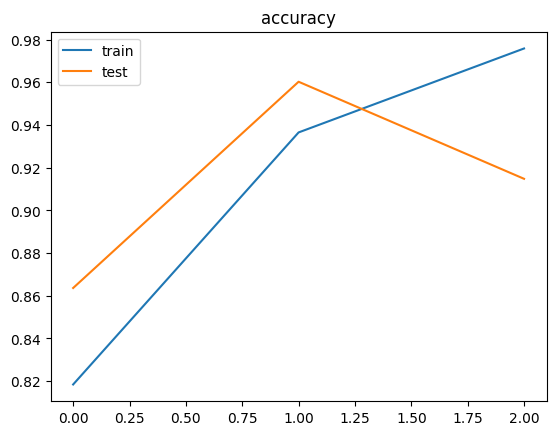

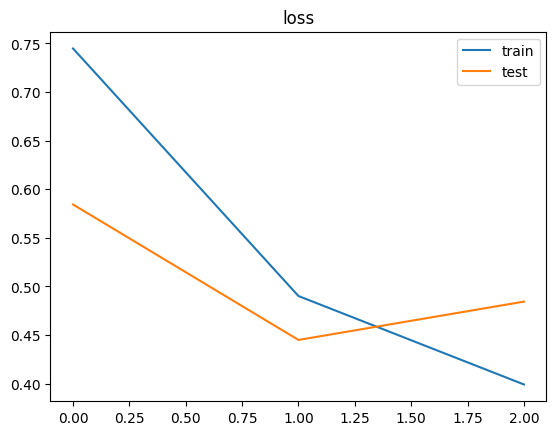

In [21]:
from tqdm import tqdm

epochs = 1
total_steps = (train_size // batch_size) * epochs
eval_steps = 20

step = 0
train_history = []
test_history = []
metrics = Metrics.empty()
for step, batch in enumerate(train_ds.as_numpy_iterator()):
    inputs, labels = batch
    state, metrics = train_step(state, metrics, inputs, labels)

    if step % eval_steps == 0 and step > 0:
        logs = metrics.compute()
        train_history.append(logs)
        print(f'[train] step {step}: {logs}')
            
        metrics = Metrics.empty()
        for inputs, labels in tqdm(
            test_ds.as_numpy_iterator(), total=len(test_ds), desc='test', leave=False):
            metrics = eval_step(state, metrics, inputs, labels)
        logs = metrics.compute()
        test_history.append(logs)
        print(f'[test]  step {step}: {logs}')

    if step == total_steps:
        break


for metric in ['accuracy', 'loss']:
    plt.figure()
    plt.title(metric)
    plt.plot([log[metric] for log in train_history], label="train")
    plt.plot([log[metric] for log in test_history], label="test")
    plt.legend()

As you can see the models learns very quickly and starts to overfit the data in the first epoch even with regularization.